# Calculando Largura de Vias

Neste Jupyter Notebook vamos validar a POC calculando a largura de vias para todo um distrito que possui Polígono de vias desenhado

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (40, 30)

In [2]:
# df_qf = gpd.read_file(f'gis/SIRGAS_SHP_quadraMDSF.shp')
# df_qv = gpd.read_file(f'gis/SIRGAS_SHP_quadraviariaed_polygon.shp')
df_l = gpd.read_file(f'gis/SIRGAS_SHP_logradouronbl.shp')

In [3]:
df_s = gpd.read_file(f'gis/SIRGAS_SHP_distrito_polygon.shp')
df_s = df_s[df_s['ds_nome'] == 'VILA MARIANA']

In [6]:
# df_pvias = gpd.read_file("./resultado/poligono_de_vias.gpkg", layer='90 - poligono de vias de vila mariana')
df_pvias = gpd.read_file('resultado/90 - poligono de vias de vila mariana.gpkg')

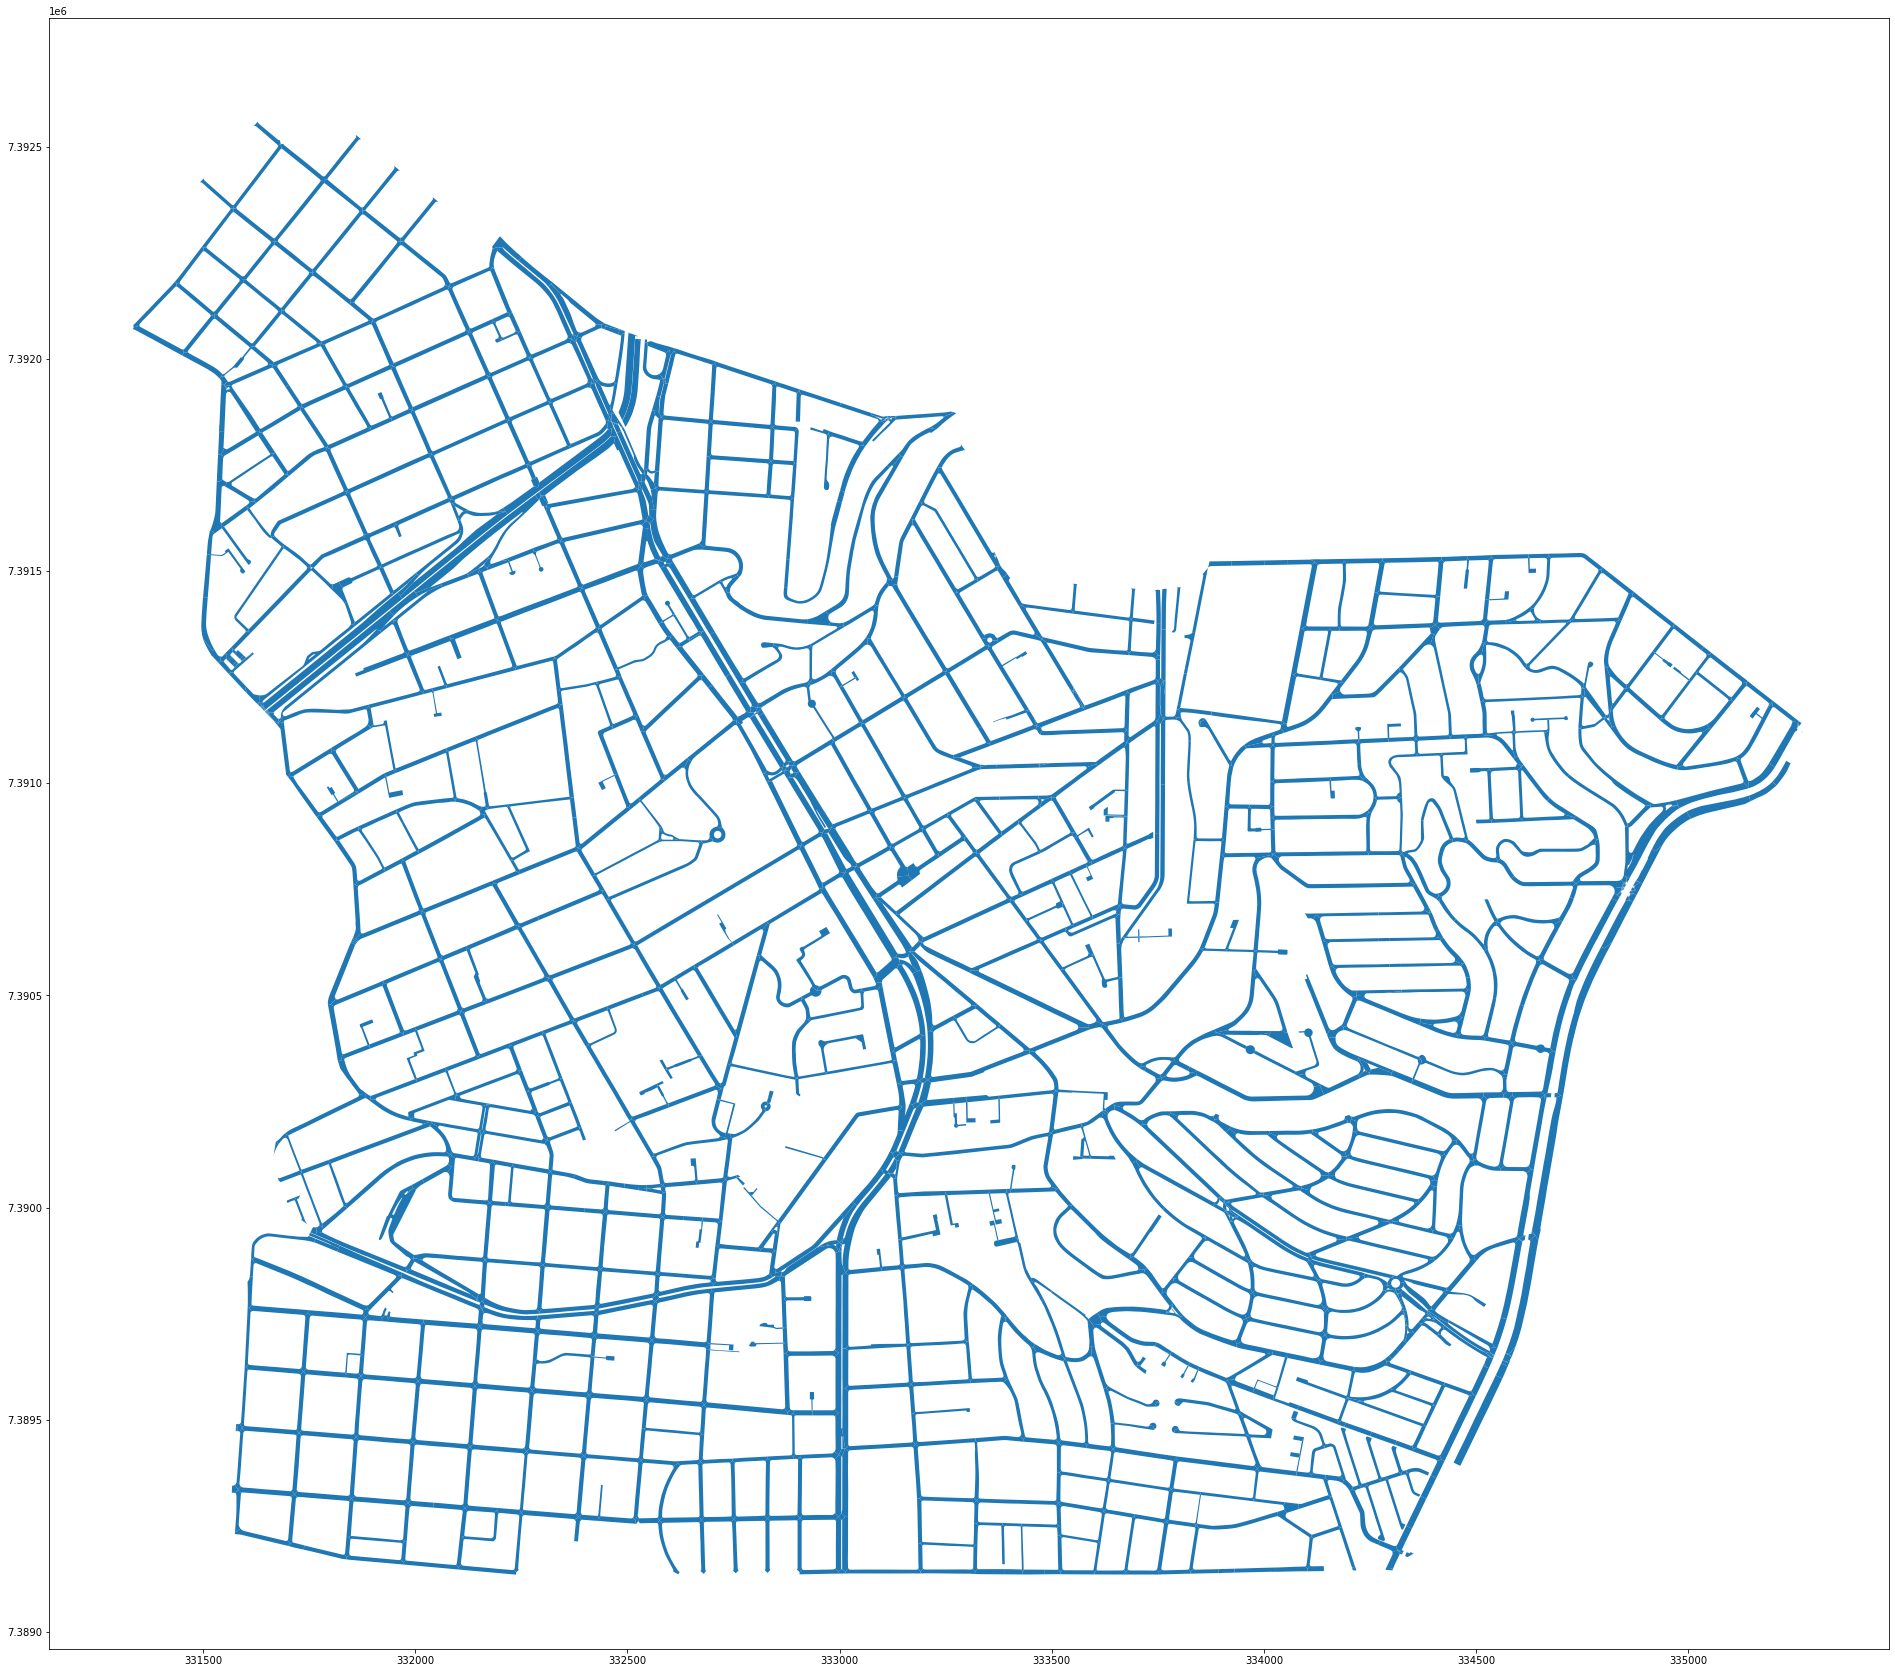

In [7]:
df_pvias.plot()

## Limitando as vias que intersectam os poligonos

In [8]:
df_s_sindex = df_s.sindex
df_l_sindex = df_l.sindex

In [9]:
# Get the bounding box coordinates of the Polygon as a list
bounds = list(df_s.bounds.values[0])

# Get the indices of the Points that are likely to be inside the bounding box of the given Polygon
l_candidate_idx = list(df_l_sindex.intersection(bounds))
l_candidates = df_l.loc[l_candidate_idx]

In [10]:
df_l = gpd.clip(l_candidates, df_s)

## Criando pontos regulares sobre as linhas da via

In [11]:
import math
from shapely.geometry import MultiPoint

dist = 12.00

points = df_l.apply(lambda x: MultiPoint([x.geometry.interpolate(((i)*dist)+dist/2+(x.geometry.length%dist)/2) 
                                              for i in range(math.floor(x.geometry.length/dist))]), 
                        axis=1)

df_points = gpd.GeoDataFrame(geometry=points)

## Quebrando a geometria do polígono de vias

In [12]:
from shapely.geometry import Point, MultiLineString, LineString, MultiPoint
from shapely.ops import substring, nearest_points, split, linemerge

In [13]:
def ponto_maior_borda(g):
    linhas_de_borda = split(MultiPoint(g.coords[:]).convex_hull.boundary, MultiPoint(g.coords[:]))
    maior_borda = max(linhas_de_borda, key=(lambda x: x.length))
    ponto_maior_borda = Point(maior_borda.coords[0])
    return ponto_maior_borda

df_pvias['geometry_ponto_inicial'] = gpd.GeoDataFrame(geometry=df_pvias.exterior.apply(lambda x: ponto_maior_borda(x)))

In [14]:
df_pvias

,geometry,geometry_ponto_inicial
0,"POLYGON Z ((335240.868 7391047.004 0.000, 3352...",POINT Z (335198.3177456815 7391003.681207987 0)
1,"POLYGON Z ((335207.390 7390994.550 0.000, 3352...",POINT Z (335142.4317388504 7390970.495225214 0)
2,"POLYGON Z ((335146.804 7390957.456 0.000, 3351...",POINT Z (335133.00438 7390950.64348 0)
3,"POLYGON Z ((335005.505 7390915.742 0.000, 3349...",POINT Z (335005.5049027237 7390915.742368137 0)
4,"POLYGON Z ((334938.200 7390852.834 0.000, 3349...",POINT Z (334930.40512 7390837.78135 0)
...,...,...
2270,"POLYGON Z ((334847.946 7390752.223 0.000, 3348...",POINT Z (334847.3282929587 7390751.623722017 0)
2271,"POLYGON Z ((334844.203 7390754.734 0.000, 3348...",POINT Z (334844.0607357367 7390753.47893831 0)
2272,"POLYGON Z ((334846.486 7390761.526 0.000, 3348...",POINT Z (334850.0319881751 7390763.177062254 0)
2273,"POLYGON Z ((334846.486 7390761.526 0.000, 3348...",POINT Z (334844.8883473975 7390760.781825628 0)


In [15]:
def bordas(r):
    ponto_inicial = r.geometry.boundary.project(r.geometry_ponto_inicial, normalized=True)
    borda = r.geometry.boundary.difference(r.geometry_ponto_inicial.buffer(1))
    borda_merged = linemerge(borda) if borda.type != 'LineString' else borda
    try:
        bordas = MultiLineString([substring(borda_merged, 0, 0.5, normalized=True), substring(borda_merged, 0.5, 1, normalized=True)])
        return bordas
    except:
        print(borda_merged)

df_pvias['geometry_bordas'] = df_pvias.apply(lambda x: bordas(x), axis=1)

LINESTRING EMPTY
LINESTRING EMPTY
LINESTRING EMPTY
LINESTRING EMPTY
LINESTRING EMPTY
LINESTRING EMPTY
LINESTRING EMPTY
LINESTRING EMPTY
LINESTRING EMPTY
LINESTRING EMPTY
LINESTRING EMPTY
LINESTRING EMPTY
LINESTRING EMPTY
LINESTRING EMPTY
LINESTRING EMPTY
LINESTRING EMPTY
LINESTRING EMPTY
MULTILINESTRING Z ((331588.8283802385 7389652.182066759 0, 331587.68884 7389633.38913 0, 331587.1456156515 7389625.175402221 0, 331587.1455595947 7389625.175405929 0, 331587.68878 7389633.38907 0, 331588.828314002 7389652.182070013 0), (331588.9592439552 7389654.175637837 0, 331590.09877 7389670.28912 0, 331591.06877 7389686.00914 0, 331593.32877 7389720.65918 0, 331594.10876 7389734.1992 0, 331594.69876 7389743.57921 0, 331595.68876 7389758.18923 0, 331596.0310109644 7389764.162659291 0, 331596.0310676021 7389764.162656046 0, 331595.68882 7389758.18929 0, 331594.69882 7389743.57927 0, 331594.10883 7389734.19926 0, 331593.55477 7389724.58137 0, 331593.32883 7389720.65924 0, 331591.06883 7389686.00919 0

MULTILINESTRING Z ((331857.0088019008 7391368.856856089 0, 331834.62479 7391350.73751 0, 331811.41627 7391332.12856 0, 331794.75855 7391318.56246 0, 331786.71782 7391312.01129 0, 331782.69739 7391308.73565 0, 331777.51103 7391304.54385 0, 331759.61554 7391290.1412 0, 331750.95644 7391283.17219 0, 331746.33825 7391279.45538 0, 331694.50397 7391237.45736 0, 331668.01241 7391215.98936 0, 331654.76664 7391205.25537 0, 331648.43169 7391200.12172 0, 331644.97627 7391197.32155 0, 331643.24179 7391195.93063 0, 331642.65977 7391195.47238 0, 331642.13686 7391194.94762 0, 331641.68062 7391194.36396 0, 331641.29767 7391193.72987 0, 331640.99359 7391193.05457 0, 331640.77275 7391192.34779 0, 331640.63837 7391191.61982 0, 331640.59241 7391190.88122 0, 331640.5924101165 7391190.881218004 0, 331632.0343730434 7391190.656063481 0, 331633.1659604781 7391206.779449974 0, 331634.64544 7391206.6988 0, 331636.1272 7391206.68593 0, 331637.60817 7391206.74088 0, 331639.0852 7391206.86351 0, 331640.55519 73912

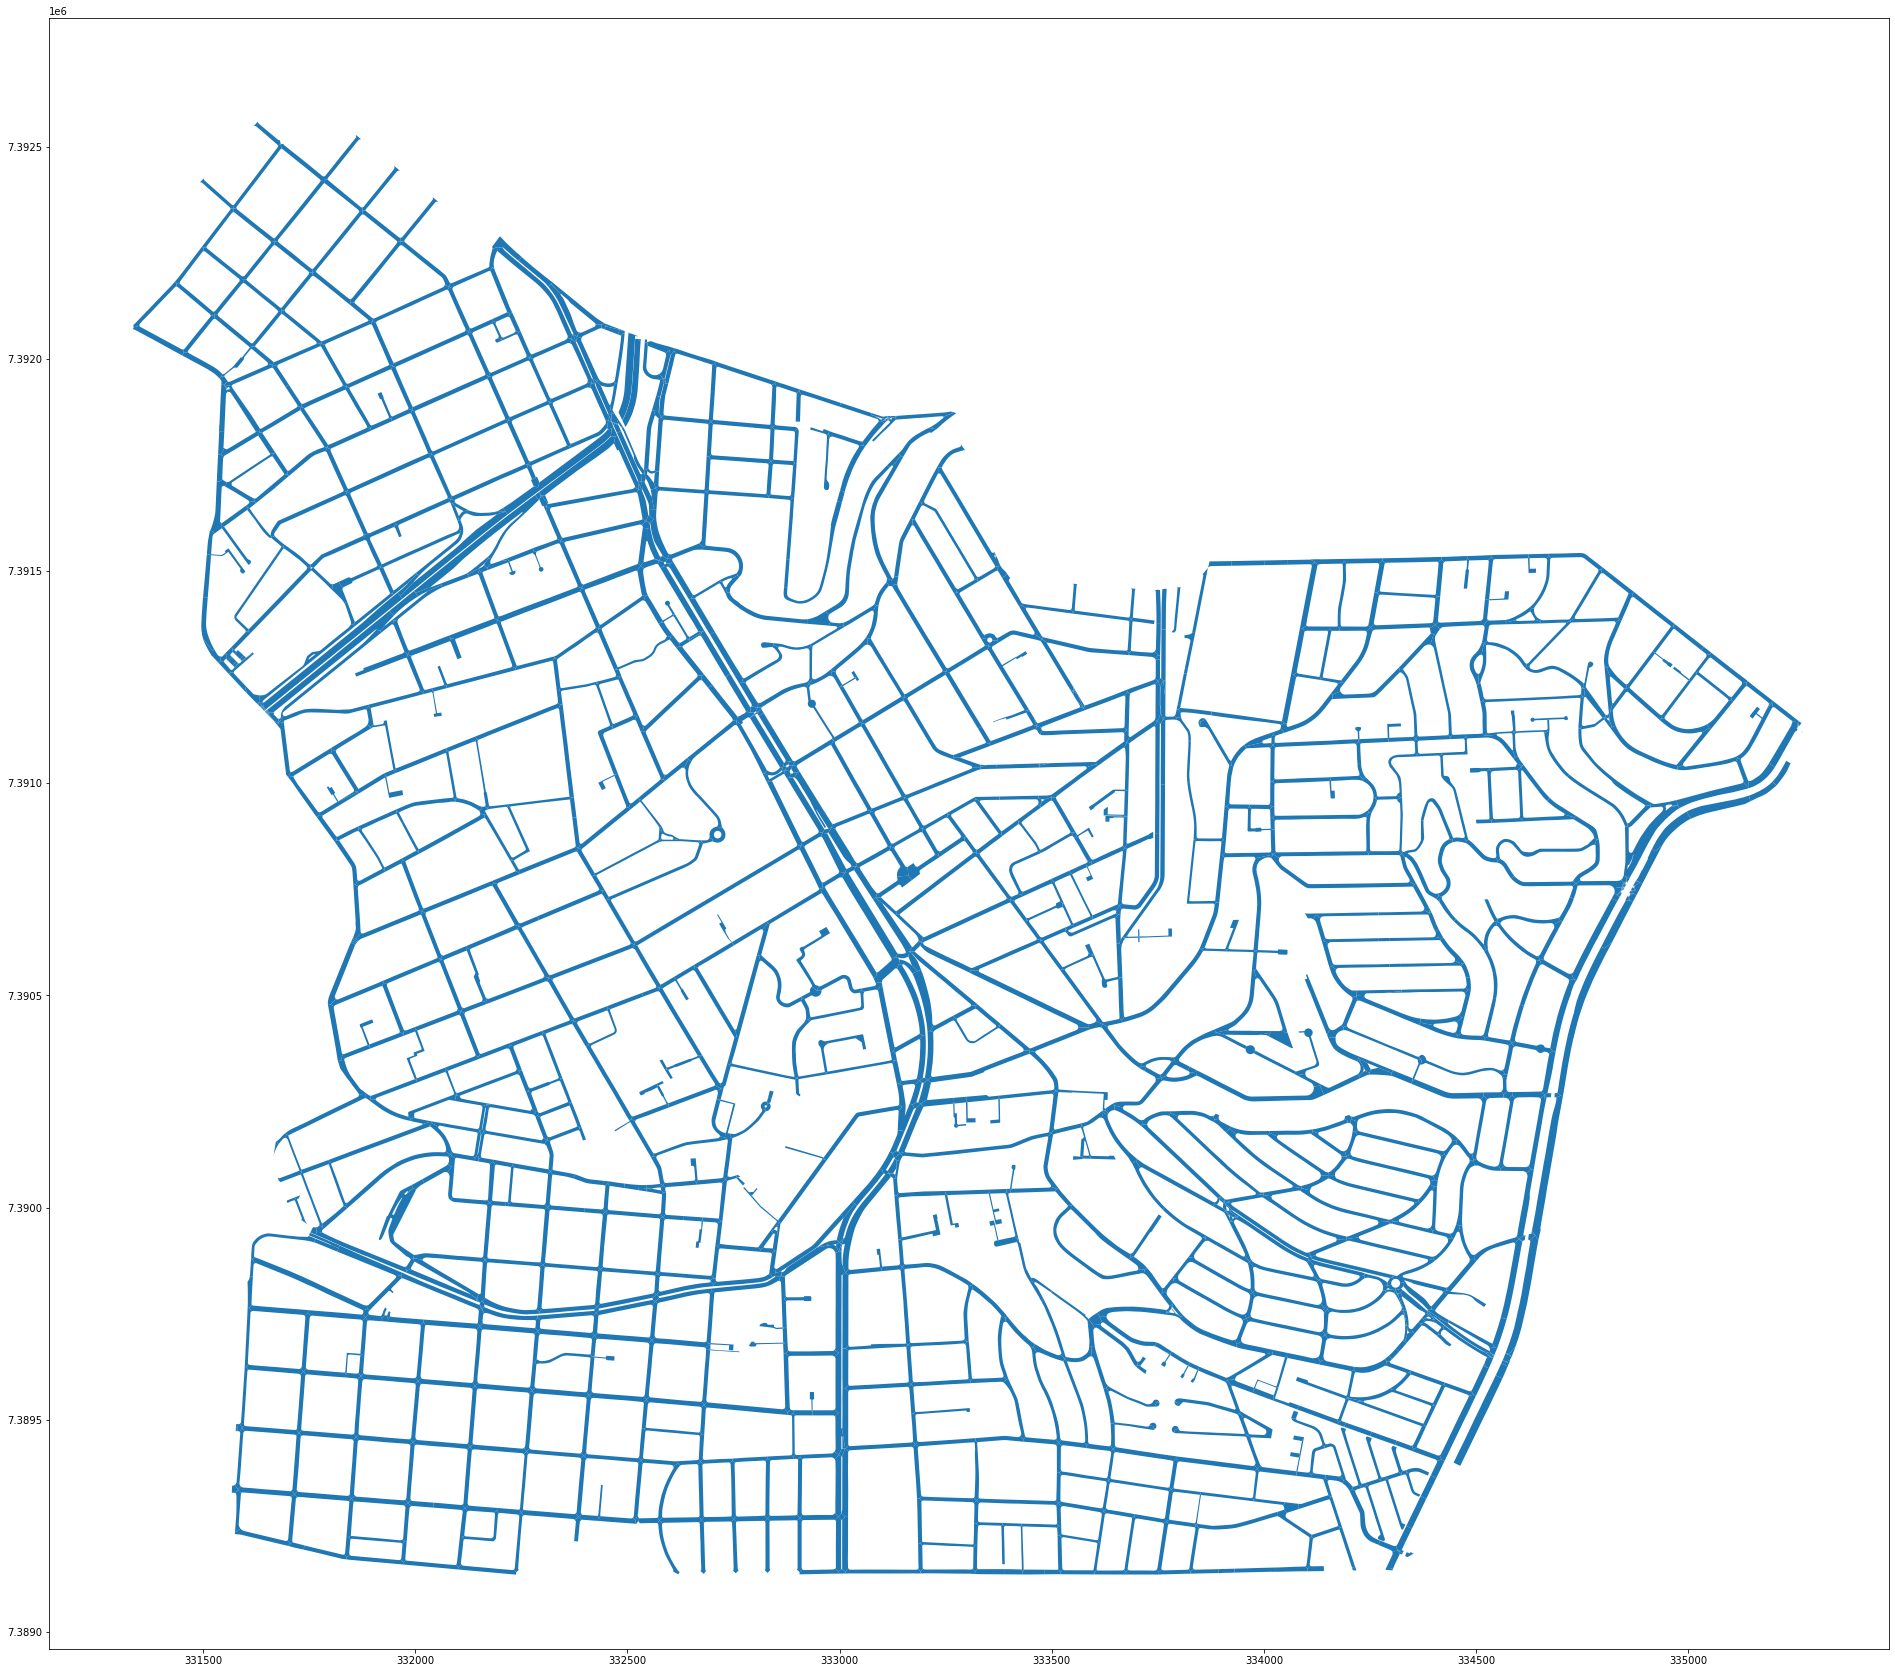

In [16]:
df_pvias.plot()

In [17]:
df_point_to_border = gpd.sjoin(df_points[~df_points.is_empty].reset_index(drop=True).explode(), df_pvias, op='within')

<ipython-input-17-23df1b2b1296>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:31983

  df_point_to_border = gpd.sjoin(df_points[~df_points.is_empty].reset_index(drop=True).explode(), df_pvias, op='within')


In [18]:
def calc_distancia(p):
    try:
        l_dist = LineString([nearest_points(p.geometry, p.geometry_bordas[0])[1], 
                             nearest_points(p.geometry, p.geometry_bordas[1])[1]])
        if p.geometry.distance(l_dist) < 1:
            return l_dist
    except: 
        print(p)
    
df_dists = gpd.GeoDataFrame(geometry=df_point_to_border.apply(lambda x: calc_distancia(x), axis=1))

geometry                      POINT (331846.1518153253 7391364.786404895)
index_right                                                          1758
geometry_ponto_inicial    POINT Z (331857.7858251929 7391369.485838686 0)
geometry_bordas                                                      None
Name: (612, 0), dtype: object
geometry                      POINT (331836.8778325805 7391357.171075352)
index_right                                                          1758
geometry_ponto_inicial    POINT Z (331857.7858251929 7391369.485838686 0)
geometry_bordas                                                      None
Name: (612, 1), dtype: object
geometry                      POINT (331827.6038498356 7391349.555745809)
index_right                                                          1758
geometry_ponto_inicial    POINT Z (331857.7858251929 7391369.485838686 0)
geometry_bordas                                                      None
Name: (612, 2), dtype: object
geometry              

geometry                      POINT (332710.1703733864 7390863.562034045)
index_right                                                          1245
geometry_ponto_inicial    POINT Z (332712.1086002637 7390898.925785222 0)
geometry_bordas                                                      None
Name: (940, 0), dtype: object
geometry                      POINT (332721.6916306153 7390865.817401656)
index_right                                                          1245
geometry_ponto_inicial    POINT Z (332712.1086002637 7390898.925785222 0)
geometry_bordas                                                      None
Name: (940, 1), dtype: object
geometry                      POINT (332727.7601826449 7390875.816030156)
index_right                                                          1245
geometry_ponto_inicial    POINT Z (332712.1086002637 7390898.925785222 0)
geometry_bordas                                                      None
Name: (940, 2), dtype: object
geometry              

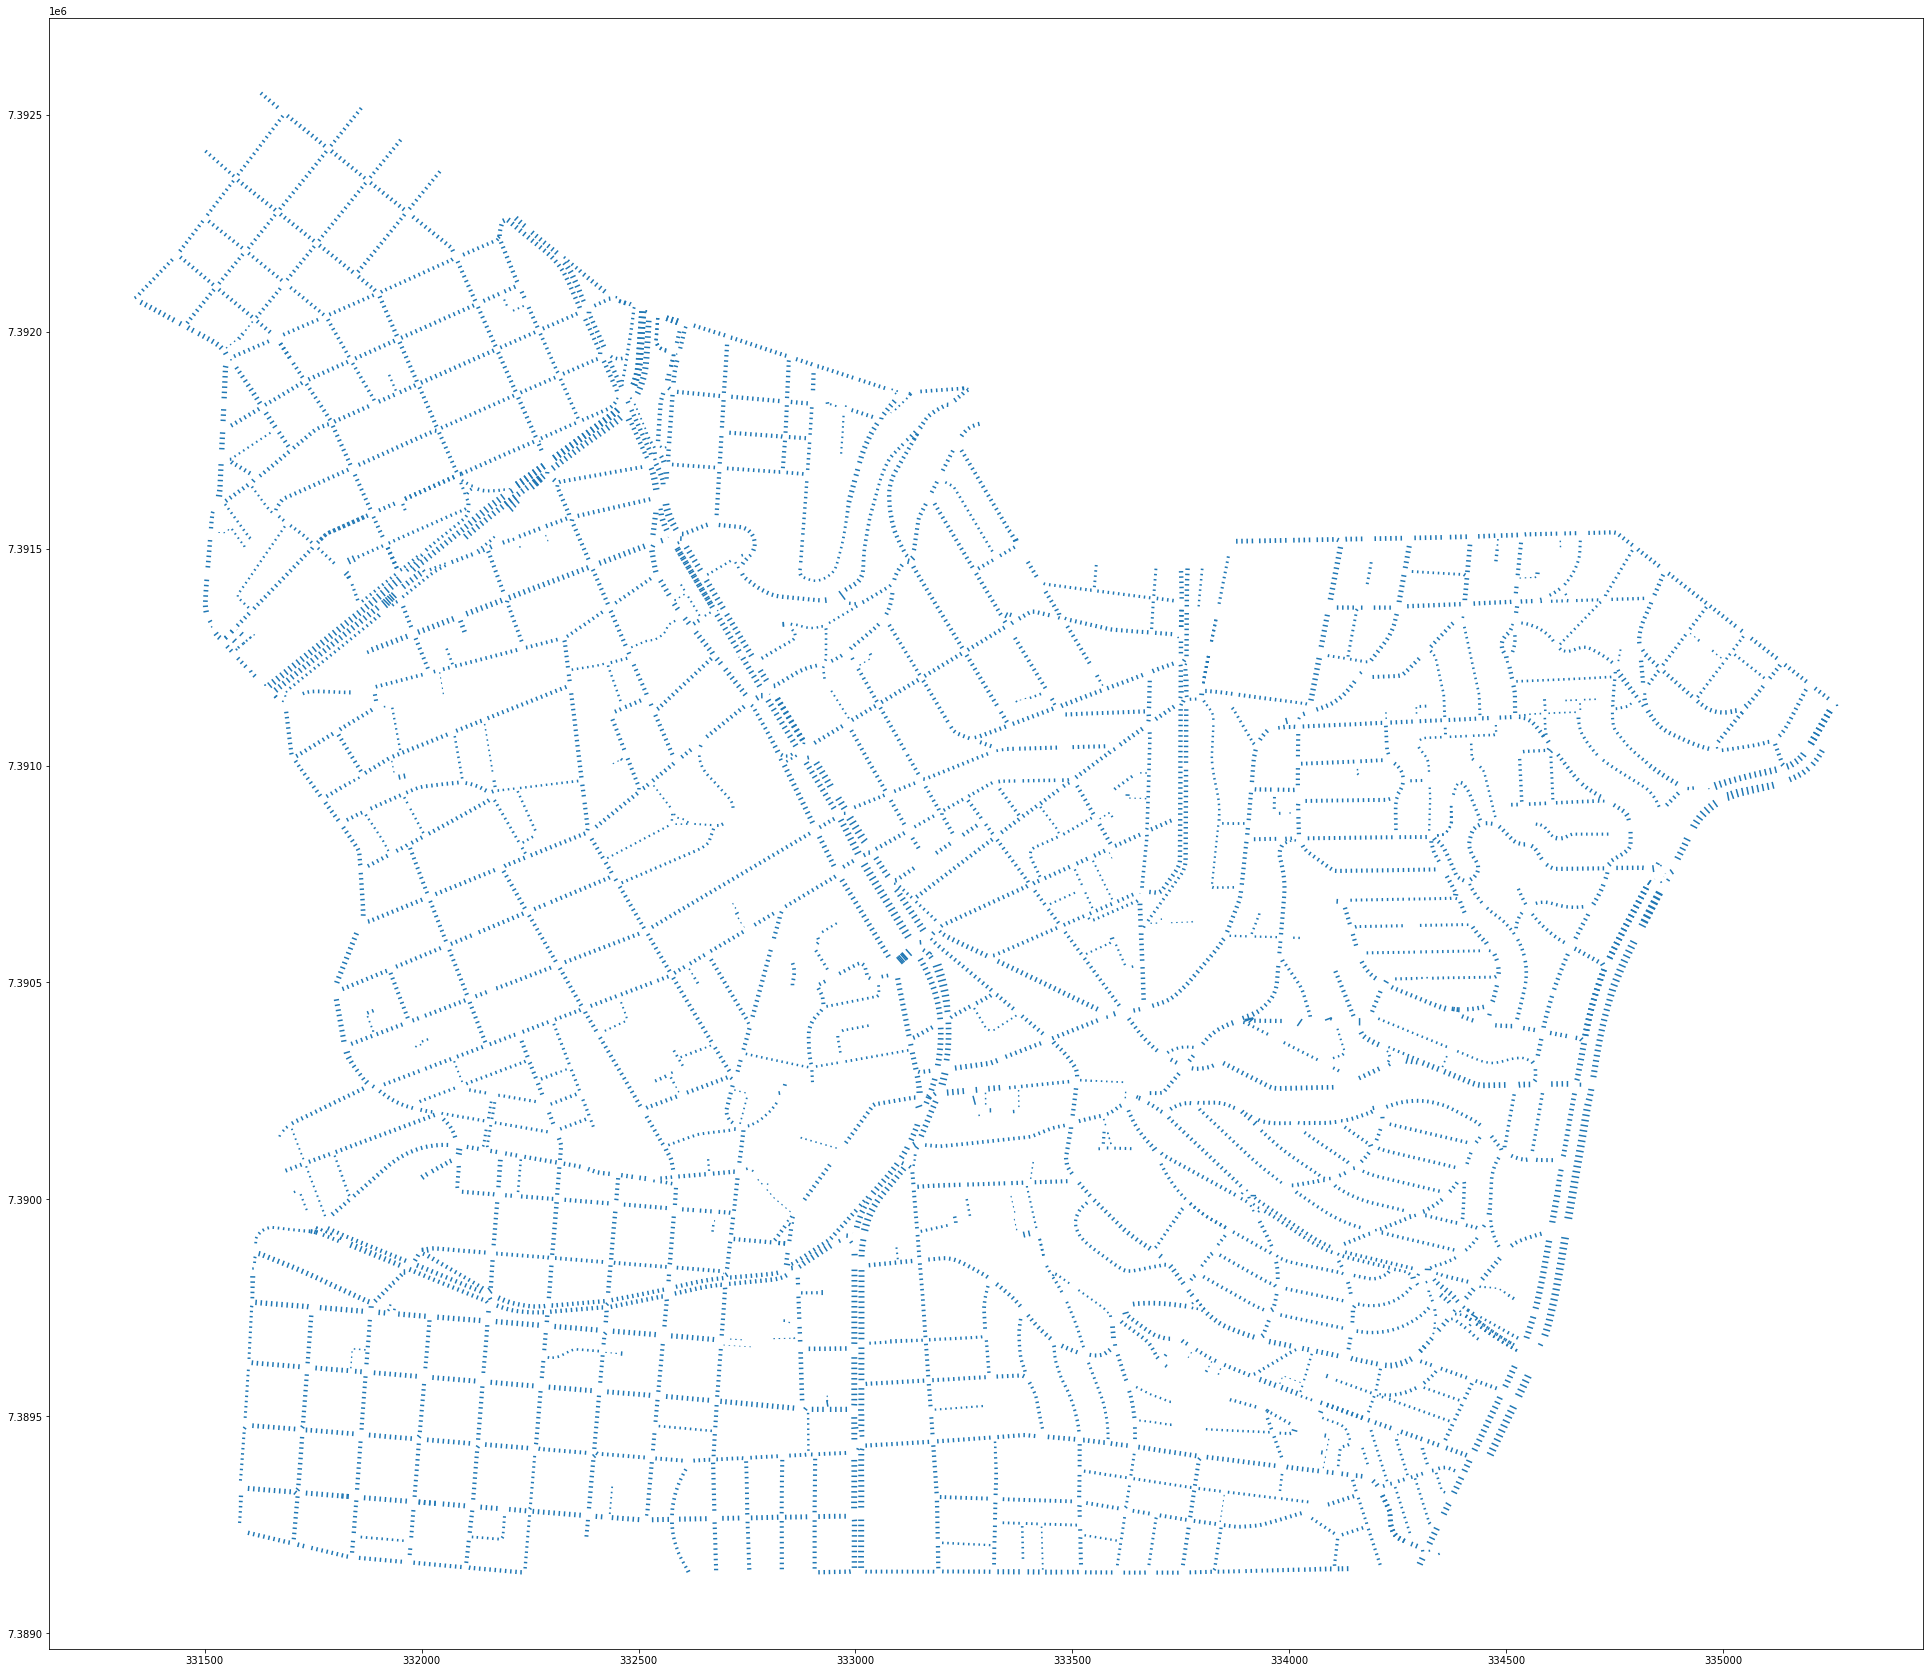

In [19]:
df_dists.plot()

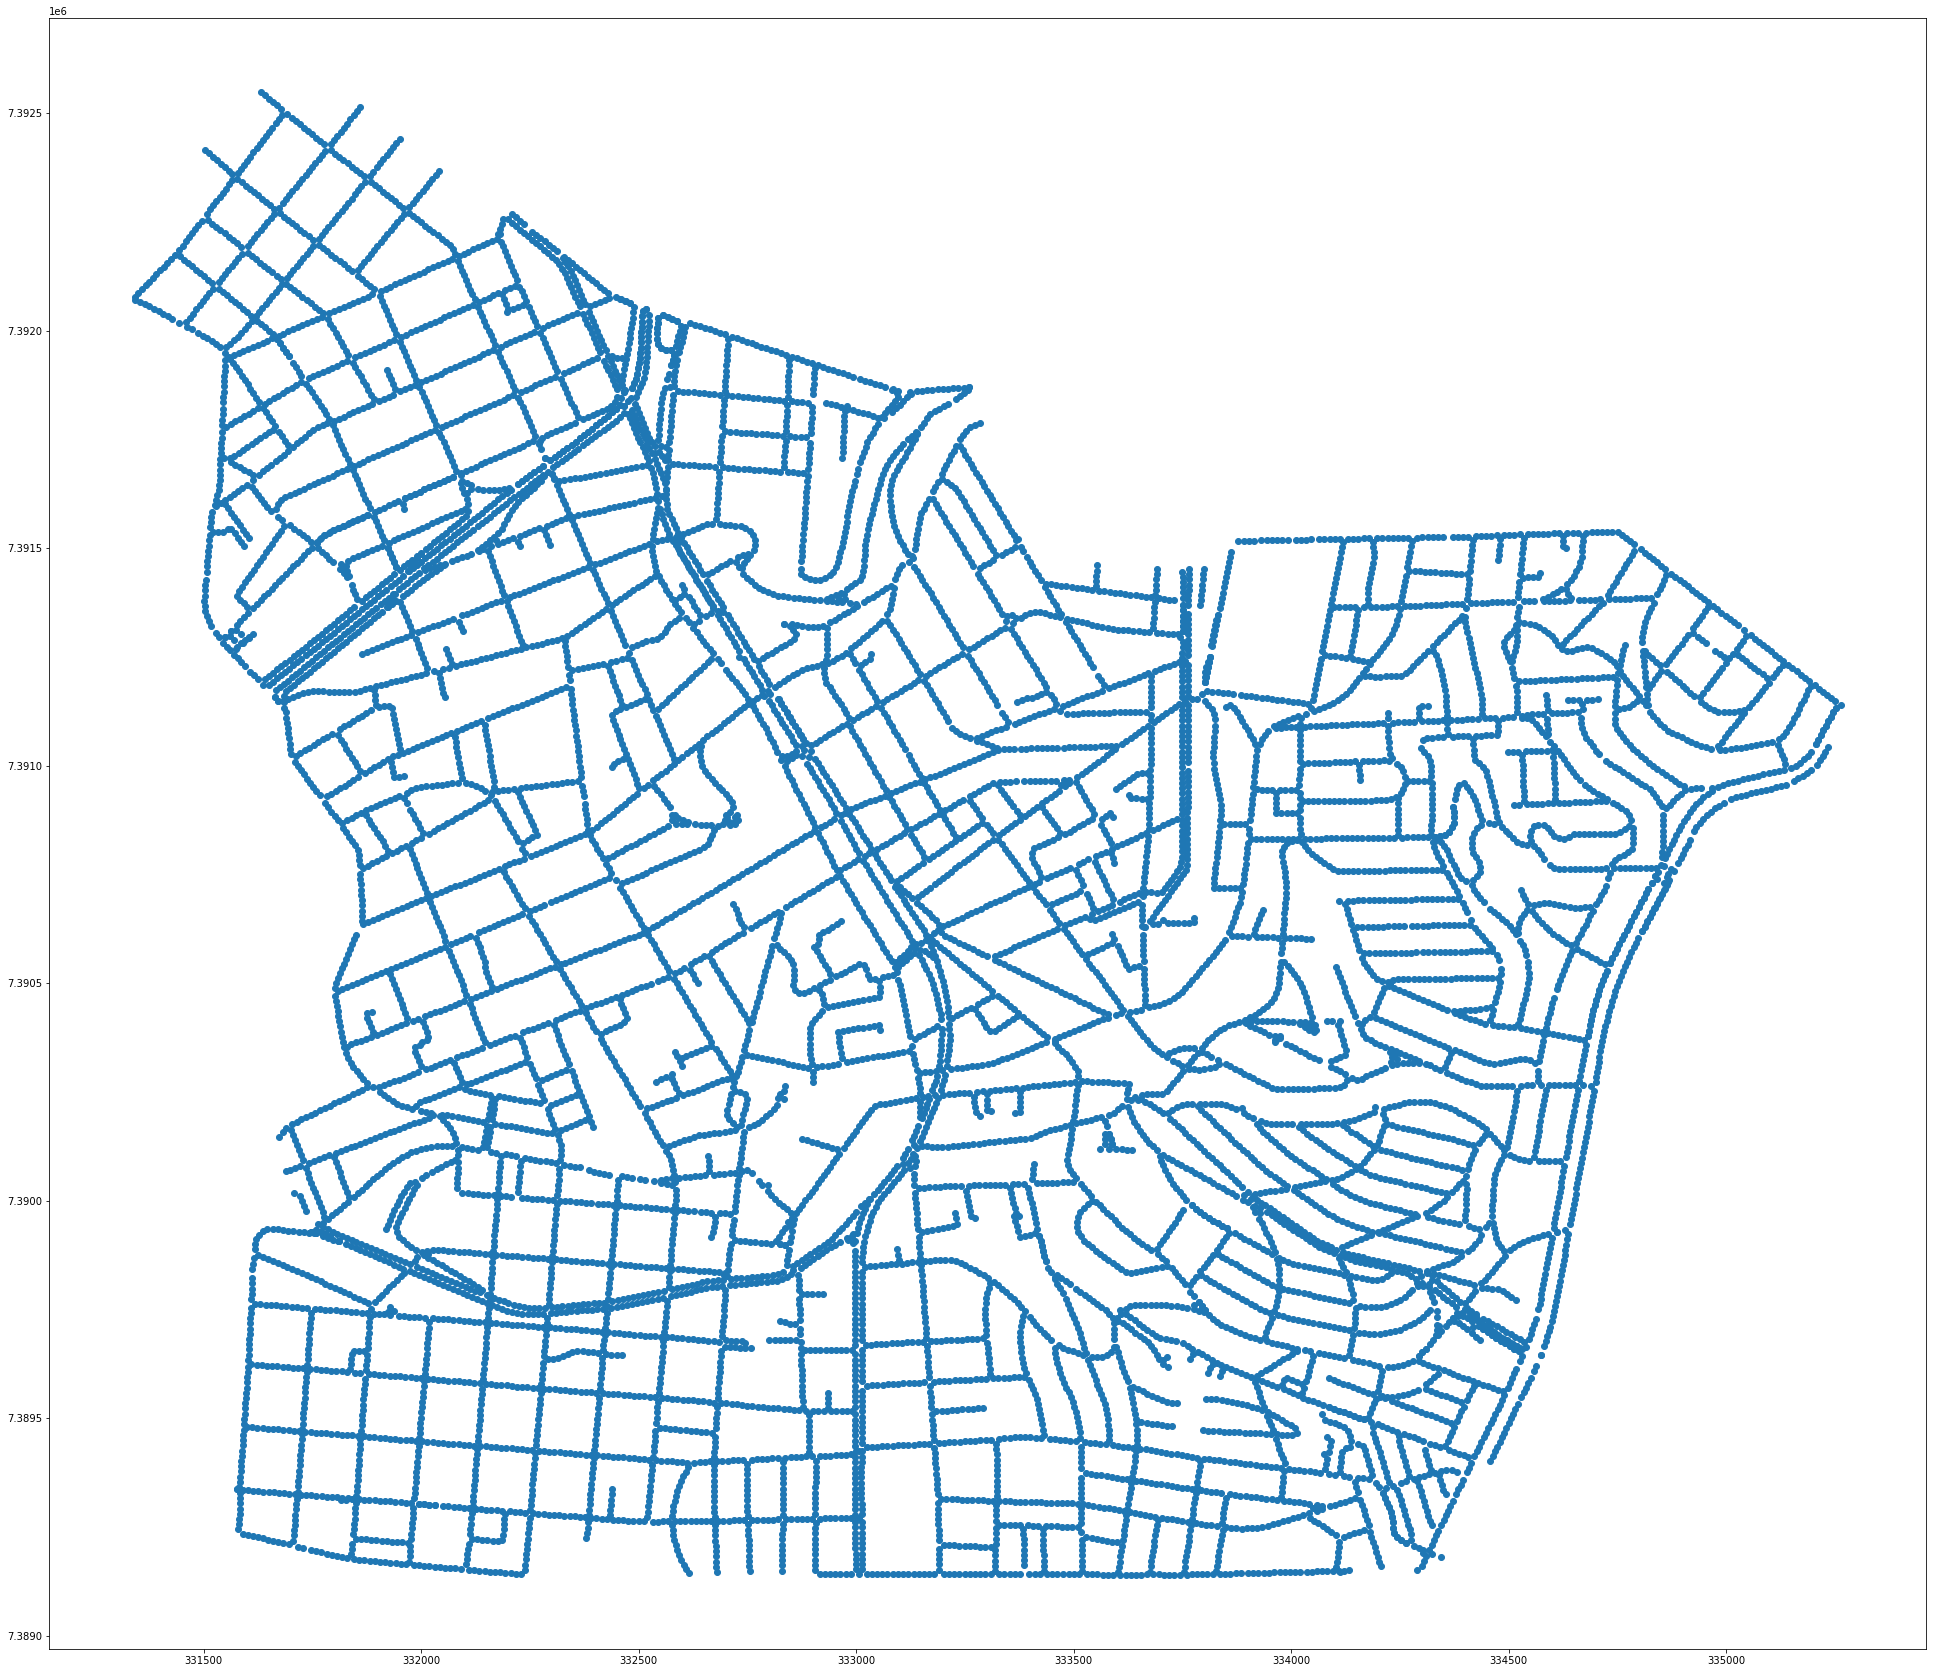

In [20]:
df_point_to_border.plot()

In [21]:
# gdf_larguras = gpd.GeoDataFrame(geometry=df_point_to_border.geometry.reset_index(drop=True))

In [22]:
# gdf_larguras.plot()

In [23]:
df_dists.reset_index(drop=True, inplace=True)

In [24]:
df_dists['largura'] = df_dists.length

In [25]:
df_dists.crs = 'EPSG:31983'

In [26]:
df_largura_pontos = gpd.GeoDataFrame({'largura':df_dists.length}, geometry=df_dists.geometry.centroid)

In [27]:
larguras = gpd.sjoin(df_pvias, df_largura_pontos, how='left', op='intersects')['largura'].groupby(level=0).agg(['min', 'max', 'mean', 'std', 'count'] )

In [28]:
df_larguras = df_pvias.join(larguras).drop(columns=['geometry_ponto_inicial', 'geometry_bordas'])
# .to_file('resultado/90 - largura de vias Vila Mariana - com largura.gpkg', driver='GPKG')

In [29]:
df_larguras.rename(columns={"min": "largura_minima",
                            "max": "largura_maxima",
                            "mean": "largura_media",
                            "std": "largura_desvio_padrao",
                            "count": "largura_contagem_amostras"},
                  inplace=True)

## Relacionando ao terreno

In [33]:
from rasterstats import zonal_stats

In [42]:
raster_stats = zonal_stats(vectors=df_larguras['geometry'], 
                           raster='/media/fernando/0dcfe7e0-23bd-4899-9552-3722ef65582e/MDT_SPTOTAL/SP_MDT_las_5m.tif')

In [46]:
# df_larguras = df_larguras.join(pd.DataFrame(raster_stats))

In [48]:
df_larguras.rename(columns={"min": "cota_minima",
                            "max": "cota_maxima",
                            "mean": "cota_media",
                            "count": "cota_contagem_amostras"},
                  inplace=True)

In [54]:
df_larguras['declividade_maxima_estatistica_percentual'] =((df_larguras.cota_maxima - df_larguras.cota_minima) / 
              (df_larguras.area / df_larguras.largura_media)) * 100

In [55]:
df_larguras

,geometry,largura_minima,largura_maxima,largura_media,largura_desvio_padrao,largura_contagem_amostras,cota_minima,cota_maxima,cota_media,cota_contagem_amostras,declividade_maxima_estatistica_percentual
0,"POLYGON Z ((335240.868 7391047.004 0.000, 3352...",12.487652,13.191490,12.836105,0.287407,4,730.413752,731.926066,731.598856,29,2.525902
1,"POLYGON Z ((335207.390 7390994.550 0.000, 3352...",12.457171,13.136217,12.732586,0.256294,5,729.975883,732.232208,731.760220,36,3.258984
2,"POLYGON Z ((335146.804 7390957.456 0.000, 3351...",16.001422,20.114535,17.939740,1.404659,10,730.195465,732.894604,732.419005,104,1.853758
3,"POLYGON Z ((335005.505 7390915.742 0.000, 3349...",17.373620,18.884896,18.276342,0.670159,7,730.638656,733.942724,732.684148,84,2.893771
4,"POLYGON Z ((334938.200 7390852.834 0.000, 3349...",15.046812,17.032535,15.617200,0.821679,5,732.225866,734.363200,733.871905,55,2.422562
...,...,...,...,...,...,...,...,...,...,...,...
2270,"POLYGON Z ((334847.946 7390752.223 0.000, 3348...",NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN
2271,"POLYGON Z ((334844.203 7390754.734 0.000, 3348...",NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN
2272,"POLYGON Z ((334846.486 7390761.526 0.000, 3348...",NaN,NaN,NaN,NaN,0,734.982712,734.982712,734.982712,1,NaN
2273,"POLYGON Z ((334846.486 7390761.526 0.000, 3348...",NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN


In [56]:
df_larguras.to_file('resultado/90 - largura de vias Vila Mariana - com largura.gpkg', driver='GPKG')

In [29]:
# df_dists.to_file('resultado/90 - largura de vias Vila Mariana.gpkg', driver='GPKG')